In [2]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

plt.rcParams['figure.figsize']=(5,5)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Aprendizaje NO supervisado

Hasta ahora cada ejemplo del conjunto de datos de entrenamiento ${\bf x}^{(i)}$ venía emparejado con un valor target $y \in \mathbb R,$ o con una etiqueta $y \in \mathcal C$, donde $\mathcal C$ es el conjunto de clases diferentes que hay.

**¿Se puede hacer algún tipo de aprendizaje automático si no tenemos $y$?**

$\fbox{Sí} \rightarrow$ aprendizaje NO supervisado.

En concreto se pueden realizar las siguientes tareas (no necesariamente disjuntas):
- Visualización de los datos  (_Data visualization_)
> En general los ejemplos _viven_ en un espacio $D$-dimensional, que NO podemos representar fácilmente en un papel o una pantalla salvo si $D\le 3$. <br>
Con ciertos "trucos" se podrían llegar a visualizar hasta $D=6$. <br>
La alternativa es reducir la dimensionalidad, tal y como hicimos con PCA. <br>
Otras técnicas más eficientes se agrupan bajo el título de **Aprendizaje de variedades** (_Manifold learning_).
- Detección de anomalías (_Anomaly detection_)
> El objetivo es aprender a reconstruir los datos mediante aprendizaje supervisado, usando los propios datos como valor objetivo. <br>
Aunque se emplean técnicas supervisadas, al no haber etiquetas se considera NO-supervisado.
- Detección de novedades (_Novelty detection_)
> El objetivo es aprender un modelo de los datos de entrenamiento que reconozca cuándo datos nuevos NO pertenecen al ese conjunto. También se le denomina  "clasificación de 1 sola clase" (_1-class classification_).
- Agrupamiento (_Clustering_)
> Consiste en asignar cada ejemplo a un grupo en función de la proximidad o lejanía de los ejemplos entre sí.

En este cuaderno aprenderemos a realizar clustering basado en centroides.<br>
El resto de técnicas se estudiarán en cursos posteriores.

# ¿Qué es un _cluster_ ?

_Cluster_ es un término inglés que significa "agrupación".<br>
Pero, al igual que en cualquier otro idioma, existen sinónimos que añaden matices, por ejemplo _collection_, _group_, etc.

Todos los elementos de un cluster tienen algo en común que se puede cuantificar (obviamente puesto que un ordenador trabaja haciendo cálculos).<br>
Así, el conjunto formado por {perro, avión, martillo, móvil, bolígrafo, niña, limón} es más bien una colección bastante heterogénea de cosas, más que un cluster.

Además, dos elementos del mismo cluster suelen tener medidas similares, por lo que su diferencia suele ser pequeña. <br>
Por el contrario, al usar esa medida con un elemento ajeno al cluster se suele obtener un valor muy diferente, por lo que su diferencia será grande.<br>
A dicha diferencia le llamaremos **distancia** entre dos elementos.

**Ideas clave**
- Un cluster tiene el matiz de que sus elementos están "próximos entre sí", es decir forman una maraña, o tienen una cierta estructura (más o menos) compacta.
- Para decidir si dos elementos están próximos entre si tenemos que se capaces de **medir la distancia** que hay entre ellos.

## Ejemplo

> Sea el siguiente conjunto de animales:
<br>&nbsp;
$$ \text{ \{ Águila, Halcón, Colibrí, Avestruz, Murciélago, Ballena, Delfín, Perro, Gato, Tiburón, Atún, Salmón, Bacalao \} }$$
<br>
- ¿Cuántos clusters hay?
- Supongamos que hay dos clusters, ¿Qué animales pondrías en cada uno de ellos?
- ¿Por qué? ¿Se pueden clusterizar de otra manera? ¿Por qué?
- ¿Y si hubiera tres clusters? ¿y cuatro clusters? ¿cuál es el número máximo de clusters que podemos hacer?

Te habrás dado cuenta de que, al no ser supervisado, podemos hacer varios clusters diferentes, todos válidos. Lo que diferencia uno de otro es como medimos la distancia entre los ejemplos.
> Un colibrí y una murciélago están más cerca que un colibrí y un avestruz si medimos la capacidad de volar. <br>
Sin embargo un colibrí y un murciélago están más lejos que un colibrí y un avestruz si medimos la clase a la que pertenecen (aves vs. mamíferos).

# Definición de distancia

La **distancia** entre dos puntos $A$ y $B$, representado como $d(A,B)$, es toda expresión matemática que cumpla 4 condiciones muy intuitivas.
1. $d(A,B)  > 0$.<br>
   O sea  que la distancia no puede ser un número negativo.
2. $d(A,B) = 0$ si y solo si $A=B$.<br>
    Es decir que la distancia entre dos puntos que están juntos es 0
3. $d(A,B) = d(B,A)$ <br>
    La distancia para ir de $A$ hasta $B$ es la misma que para volver de $B$ hacia $A$.
4. $d(A,B) + d(B,C) \geq d(A,C)$<br>
    O sea que el camino para ir desde $A$ hasta $C$ directamente es igual de largo o menor que si llego hasta $C$ por otro camino que pase por $B$.

## Distancia Manhattan y Euclidea

Dos distancias muy típicas son la Manhattan y la Euclidea.
En ambos casos asumimos que tenemos dos puntos en un espacio $D$ dimensional; es decir $A, B \in \mathbb R^{D}$ tal que $A = (a_1, a_2, \ldots, a_D)$ y $B = (b_1, b_2, \ldots, b_D)$

- La distancia Manhattan se define como:
$$
d(A, B) = \vert b_1 - a_1 \vert + \vert b_2 - a_2 \vert + \cdots + \vert b_D - a_D \vert
$$
- La distancia Euclidea es:
$$
d(A,B)=\sqrt{(b_1-a_1)^2 + (b_2-a_2)^2 + \cdots +(b_D-a_D)^2 }
$$

La distancia euclidea se puede generalizar para cualquier exponente $m$ haciendo:
$$
d(A,B)=\left((b_1-a_1)^m + (b_2-a_2)^m + \cdots +(b_D-a_D)^m \right)^{\frac{1}{m}}
$$
(conocida como distancia Minkowski)

En la figura de abajo se muestra una interpretación de las distancias Manhattan y Euclidea para $D=2$.
- A la izquierda se calcula $d(A,B)$ con la distancia Manhattan.
- A la derecha se calcula también con la distancia Euclidea (en verde).

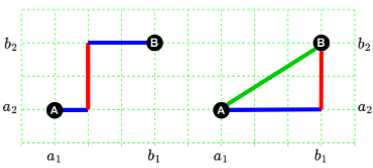

# Algoritmo K-medias (_K-means_)

**Previo**

- Debemos elegir una métrica para la distancia.
- Debemos elegir el número de clusters que queremos hacer. <br>
  $K$ será ese número.
- Llamaremos __centroide__ al valor medio, es decir calculado con la media, de todos los ejemplos asignados a un mismo cluster.
> - Un centroide es un ejemplo que representa el "centro" de un cluster, en torno al cual se agruparán los ejemplos que hayamos decido asignar a dicho cluster.  
> - Por este motivo frecuentemente también se le denomina **prototipo** del cluster.
> - Como cada ejemplo esta representado por un vector, el centroide es otro vector del mismo tamaño, pero en modo alguno tiene que ser obligatoriamente uno de los ejemplos del conjunto de datos.

**Incialización**

- Elegir aleatoriamente la posición de $K$ centroides.
    
**Algoritmo**

1. Medir la distancia del centroide a cada ejemplo del conjunto de datos.
    > Como resultado tendremos una lista de distancias por cada centroide, con tantos elementos como ejemplos haya en el conjunto de datos dado.

2. Asignar cada ejemplo al cluster del centroide más cercano.
    > En este paso recorremos cada uno de los ejemplos mirando cuál de los centroides está más próximo. <br>
    Como cada centroide es el prototipo de un cluster, el que quede más cerca del ejemplo mirado será al que asignemos dicho ejemplo.

3. Actualizar el centroide de cada cluster calculando la media de todos sus ejemplos.
    > Al terminar, calculamos el centroide de todos los ejemplo asignados a un mismo cluster, y repetimos esta operación para todos los centroides.

4. Volver al paso 1 y repetir un cierto número de veces fijado al inicio o hasta que los centroides ya no cambien de posición.
    > Es importante resaltar que, al volver al paso 1 los ejemplos dejan de pertenecer al cluster que les habíamos asignado. <br>
    Se debe repitir todo el proceso. <br>
    Al repetir el paso 2 será cuando volvamos a asignar cada ejemplo a un cluster.


En la figura de abajo se puede ver una secuencia de cómo se obtienen dos clusters a partir de un conjunto de ejemplos en $\mathbb R ^2$.

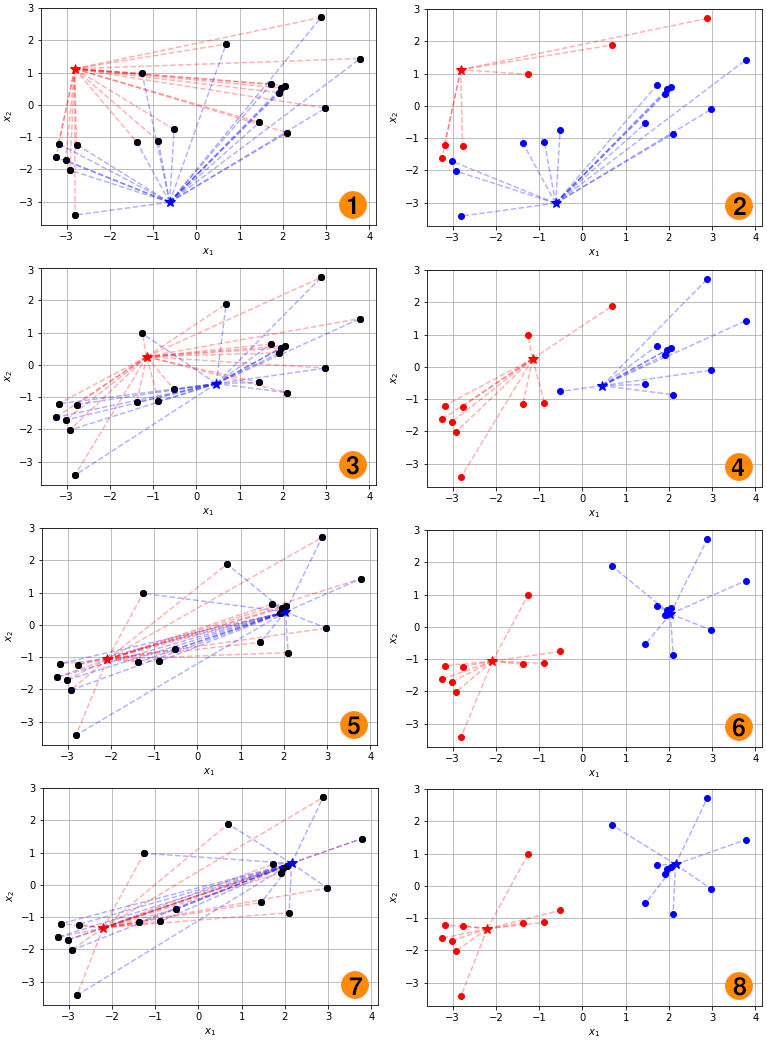

También se puede ver como GIF animado


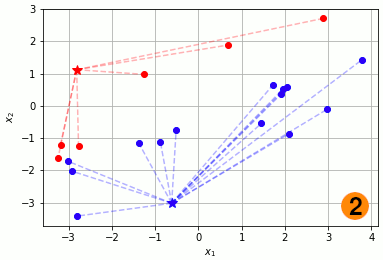

## Implementación

Comenzamos creando diferentes métricas para la distancia entre ejemplos.

In [3]:
def distancia_euclidea(A, B):
  return np.sqrt(np.sum((A - B) ** 2))

def distancia_manhattan(A, B):
  return np.sum(np.abs(A-B))

Creamos una función para inicializar los centroides.

La inicialización es aleatoria. <br>
Se deja como ejercicio crear una incialización alternativa que seleccione, de manera aleatoria $K$ ejemplos del conjunto de datos dado.

In [4]:
def inicializar_centroides(K):
  return np.random.rand(K, 2)

def inicializar_centroides_de_datos(K, X):
  # Esta función elige K ejemplos aleatorios de X como centroides iniciales
  indices = np.random.randint(0, len(X), K)
  centroides = X[indices]
  return centroides

Creamos una función para asignar los ejemplos a los clusters. <br>
Cada cluster es una lista que contiene los índices de los ejemplos asignados a él en el conjunto de datos dado.
Las $K$ listas se agrupan en una lista `cluster`

In [5]:
def crear_clusters(K, X, centroides):
  clusters = [[] for _ in range(K)]
  for punto_idx, punto in enumerate(X):
      centroide_mas_cercano_idx = np.argmin(
          [distancia_euclidea(punto, centroide) for centroide in centroides]
      )
      clusters[centroide_mas_cercano_idx].append(punto_idx)
  return clusters

Creamos una función para calcular los nuevos centroides como el valor medio de los ejemplos asignados al cluster.

In [6]:
def calcular_nuevos_centroides(K, clusters, X):
  centroides = np.zeros((K, X.shape[1])) #<- reserva de memoria
  for idx, cluster in enumerate(clusters):
      nuevo_centroide = np.mean(X[cluster], axis=0)
      centroides[idx] = nuevo_centroide
  return centroides

Finalmente creamos el script para ejecutar K-means sobre un conjunto $X$ de juguete, con 150 ejemplos de 2 características.

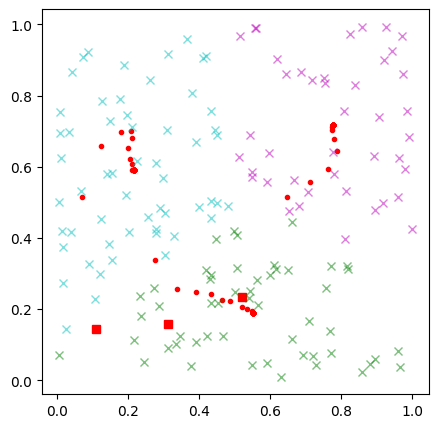

In [ ]:
np.random.seed(seed)
max_iters = 30
K = 3
N = 150
D = 2
X = np.random.rand(N, D)

centroides = inicializar_centroides(K)
plt.plot(centroides[:,0], centroides[:,1], 'rs')
for _ in range(max_iters):
    clusters = crear_clusters(K, X, centroides)
    centroides_anteriores = centroides
    centroides = calcular_nuevos_centroides(K, clusters, X)
    plt.plot(centroides[:, 0], centroides[:, 1], 'r.')

colors = 'mgc'
for k in range(K):
    plt.plot(X[clusters[k],0], X[clusters[k],1], f"{colors[k]}x", alpha=0.5)
plt.show()

## Variante K-medianas (_K-medians_)

La función `calcular_nuevos_centroides` que hemos definido utiliza la media (`mean`) para actualizar los centroides.

Se ha observado empíricamente que K-medianas es más robusto frente a ejemplos _outliers_.



## Variante K-medoides (_k-medoids_)

En este caso los centroides deben ser ejemplos del conjunto de datos.

# Selección de $K$

El número de clusters $K$ es elección del humano; por tanto nos interesa tener un método objetivo para decirlo.



## Método del codo

El método del codo (_elbow_) consiste en representar en una gráfica una métrica que nos informe sobre lo buena o mala que es la selección de $K$.

En estas gráficas, a veces, se aprecia un "codo" en el valor de $K$ que deberíamos elegir.

Respecto a las posibles métricas, tenemos:

**WCSS o Inercia**

WCSS son las iniciales en inglés de _within cluster sum of squares_
(que es más útil para recordar como se calcula que _inercia_).

Efectivamente consiste en sumar la distancia desde el centroide de un cluster a cada ejemplo asignado a él y luego sumar todos los resultados; es decir:
$$
{\rm WCSS}(K) = \sum_{j=1}^{K} \sum_{i=1}^{N_j} d \left( {\bf x}^{(i)} - {\bf \bar x}_j \right)^2,
$$
donde:
- $j = 1, \ldots, K$ es el índice del cluster que estamos mirando en ese instante del cálculo, con $K$ el número de clusters que hemos realizado.
- $i = 1, \ldots, N_j$ es el índice del ejemplo asignado al cluster $j$ que estamos mirando en ese instante del cálculo, con $N_j$ el número de ejemplos total asignados al cluster $j$-ésimo.
- ${\bf \bar x}_j$ representa el centroide del cluster $j$-ésimo.
- $d$ es la distancia usada.

Este cálculo se hace para varios $K$ y después se representa el WCSS frente a $K$ para visualizar el codo (si es que se ve).


### Ejemplo

Para este ejemplo utilizaremos la clase `Kmeans` de Scikit-Learn. <br>
Queda como ejercicio codificar el método desde cero, como se ha hecho con el algoritmo K-medias anteriormente.

In [ ]:
#%% -- Crear el conjunto de datos (de juguete) con la función `make_moons`
#      ( generamos 2 blobs bidimensionales )

n_dims = 2
centers = [[-1.5,-1.5], [1.5,1.5]]
n_samples = 400

X, _ = make_blobs(n_samples=n_samples, centers=centers,
                  n_features=n_dims, random_state=seed)

feature_names = ['x_1','x_2']
X = pd.DataFrame(X, columns=feature_names)

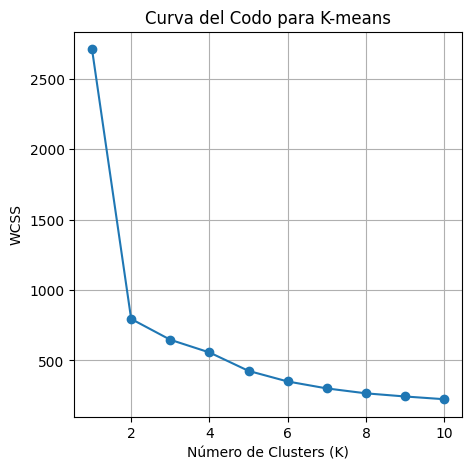

In [ ]:
# Encuentra el valor óptimo de K utilizando la curva del codo
K_max = 10
inertia = []
clusters = []
for k in range(1, K_max+1):
    kmeans = KMeans(n_clusters=k,
                    random_state=seed, n_init='auto')
    kmeans.fit(X)
    clusters.append(kmeans)
    inertia.append(kmeans.inertia_)

# Grafica la curva del codo
plt.plot(range(1, K_max+1), inertia, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS')
plt.title('Curva del Codo para K-means')
plt.grid(True)
plt.show()

Se puede apreciar un "codo" en $K=2$ porque la caida de WCSS cuando $K$ pasa de 1 a 2 es tan grande como la caida entre 2 y 10.

También podemos comprobar que los centroides obtenidos están cerca de los centroides reales.

In [ ]:
clusters[1].cluster_centers_

array([[-1.65, -1.65],
       [ 1.46,  1.43]])

## Método _silhouette_

El _silhouette score_ es una medida de la similitud de una ejemplo respecto de los otros ejemplos del mismo cluster al que han sido asignados; y al mismo tiempo de la no-similitud con los ejemplos de otros clusters.

- Para cada ejemplo ${\bf x}^{(i)}$ asignado al cluster $k$ se calcula
$$
a(i) = \frac{1}{N_k -1}\sum\limits_{j=1}^{N_j} d({\bf x}^{(i)}, {\bf x}^{(j)}),
$$
donde ${\bf x}^{(j)}$ son ejemplos del cluster $k$.

> Esta expresión es una medida de lo NO-similar que ${\bf x}^{(i)}$ respecto a los otros ejemplos del cluster al que ha sido asignado.

> Cuando **menor** sea el valor $a(i)$, más pequeñas serán las distancias calculadas, es decir más similares serán los ejemplos que estamos comparando, y por tanto **mejor** será la asignación.<br>
En estos casos se dice que el ejemplo $i$ es _similar_ al cluster $k$.

- De un modo similar podemos definir la no-similitud de un ejemplo ${\bf x}^{(i)}$ con un cluster $\ell$ diferente al que ha sido asignado (que es $k$):
$$
b(i) = \mathop{\min}\limits_{\ell \neq k} \left( \frac{1}{N_\ell}\sum\limits_{j=1}^{N_\ell}  d({\bf x}^{(i)}, {\bf x}^{(j)}) \right)
$$

> El resultado del paréntesis es un escalar, por lo que el proceso se debe repetir para cada cluster al que el ejemplo  ${\bf x}^{(i)}$ NO ha sido asignado. <br>
De esta manera obtenemos un vector de valores, sobre el que se calcula el mínimo.

> El cluster que da lugar el valor mínimo es el **cluster vecino**, y es el "siguiente mejor" donde encajaría el ejemplo ${\bf x}^{(i)}$.

- Finalmente se define el _silhouette score_ para el ejemplo ${\bf x}^{(i)}$:
$$
s(i) =
\left\lbrace
 \begin{array}{lccccc}
  1 - \frac{a(i)}{b(i)} & {\rm si} & a(i) < b(i) \\
  0 & {\rm si} & a(i) = b(i) \\
  \frac{b(i)}{a(i)} -1 & {\rm si} & a(i) > b(i) \\
 \end{array}
\right.
$$

> $s(i)$ puede tomar cualquier valor en el intervalo $[-1,+1]$.
- $+1$ significa que ${\bf x}^{(i)}$ está muy alejado del cluster vecino.
- $0$ significa que ${\bf x}^{(i)}$ está muy cerca de la frontera entre dos clusters.
- $-1$ significa que ${\bf x}^{(i)}$ estaría mejor asignado a otro cluster.

### Ejemplo

Para n_clusters = 2 El promedio silhouette_score es: 0.5955207405315346
Para n_clusters = 3 El promedio silhouette_score es: 0.7613478432173022
Para n_clusters = 4 El promedio silhouette_score es: 0.7911042588289479
Para n_clusters = 5 El promedio silhouette_score es: 0.6886109760881518
Para n_clusters = 6 El promedio silhouette_score es: 0.5598581341316637


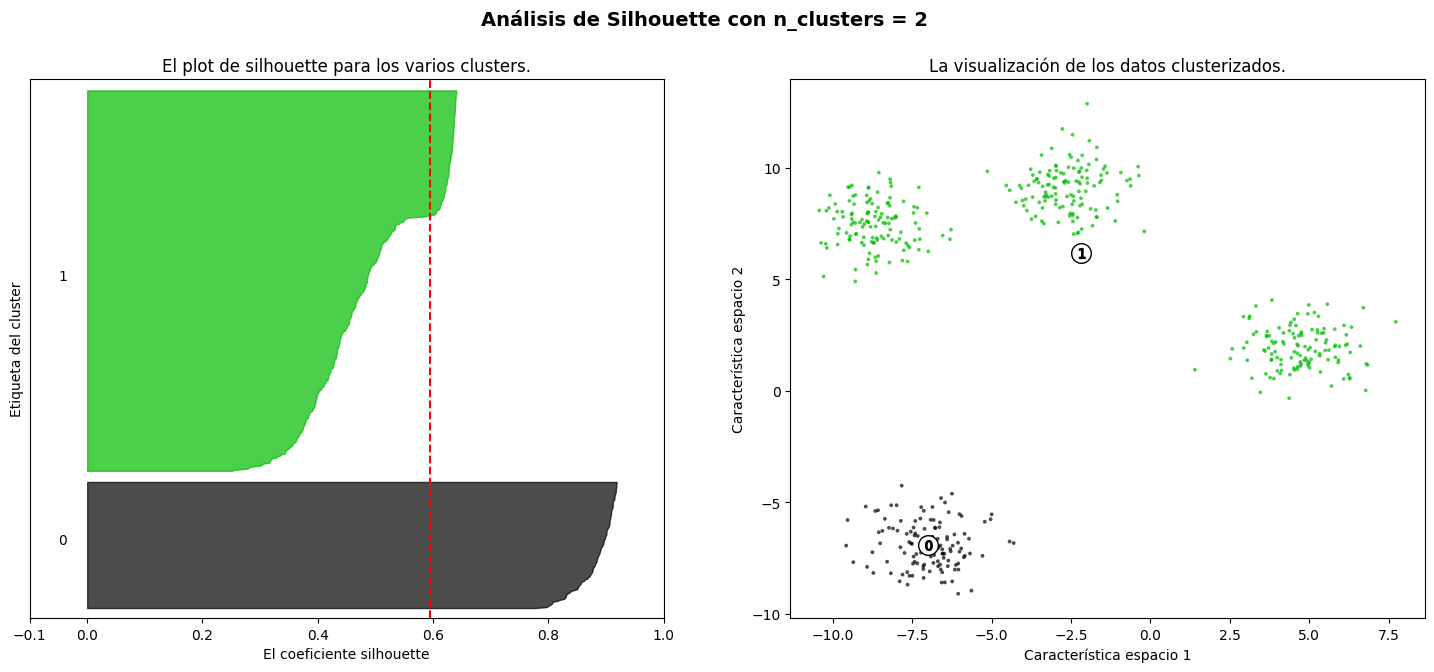

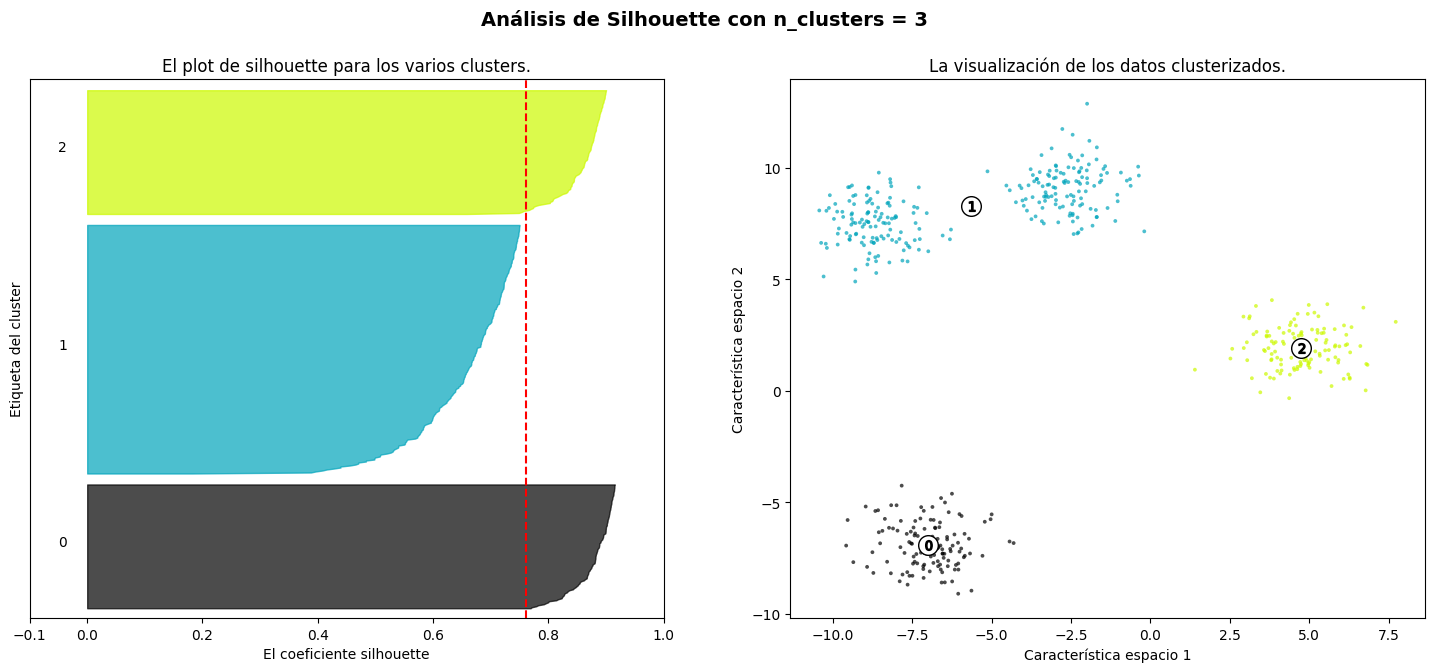

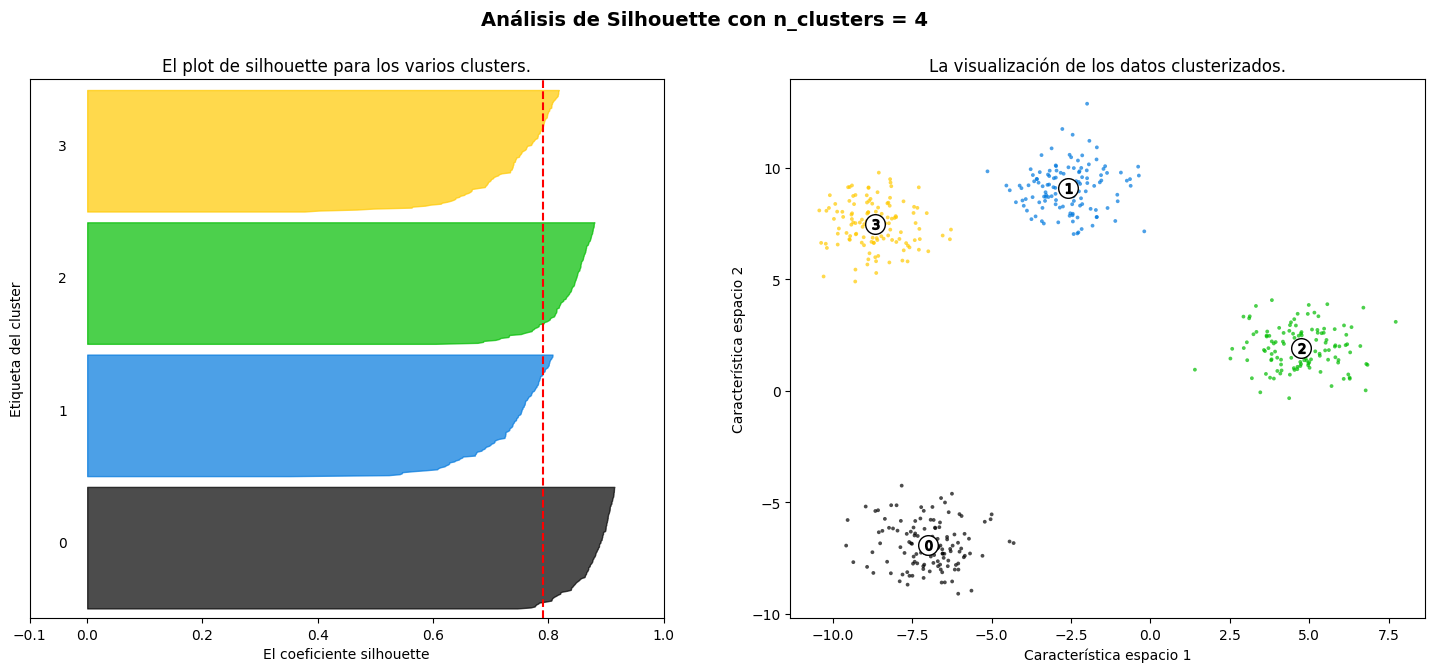

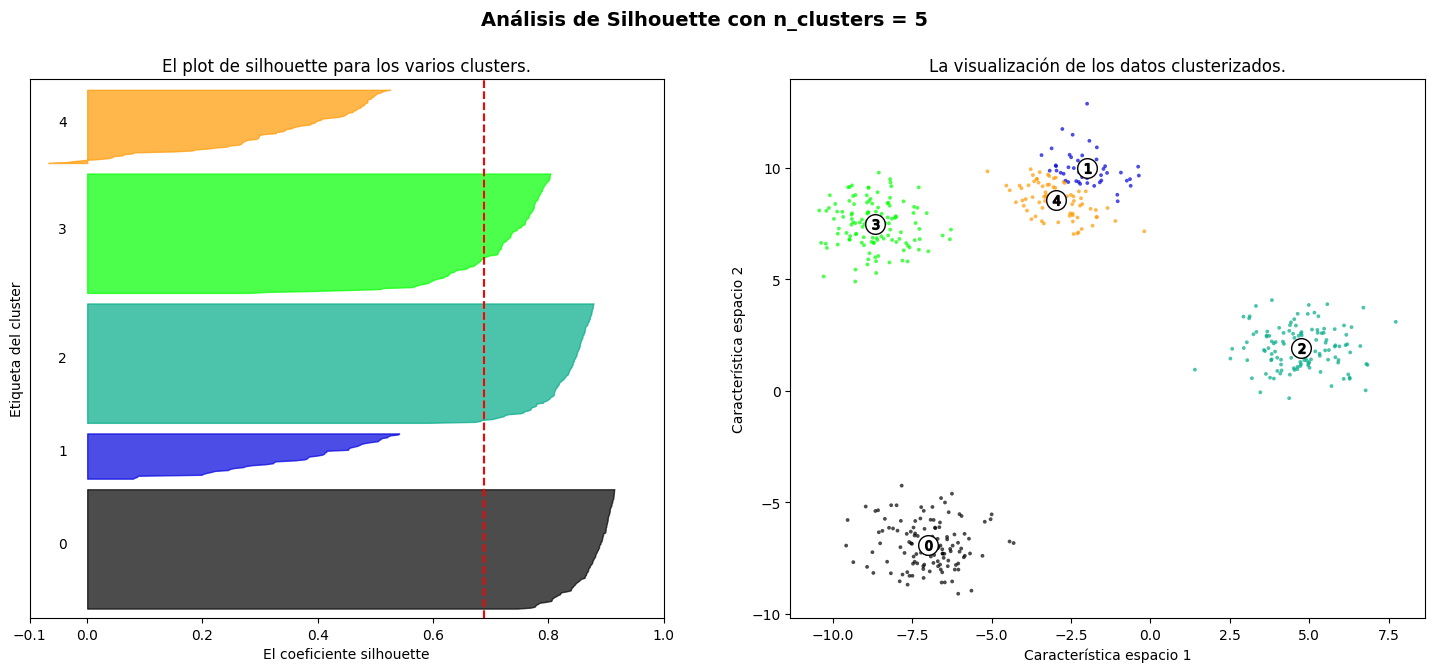

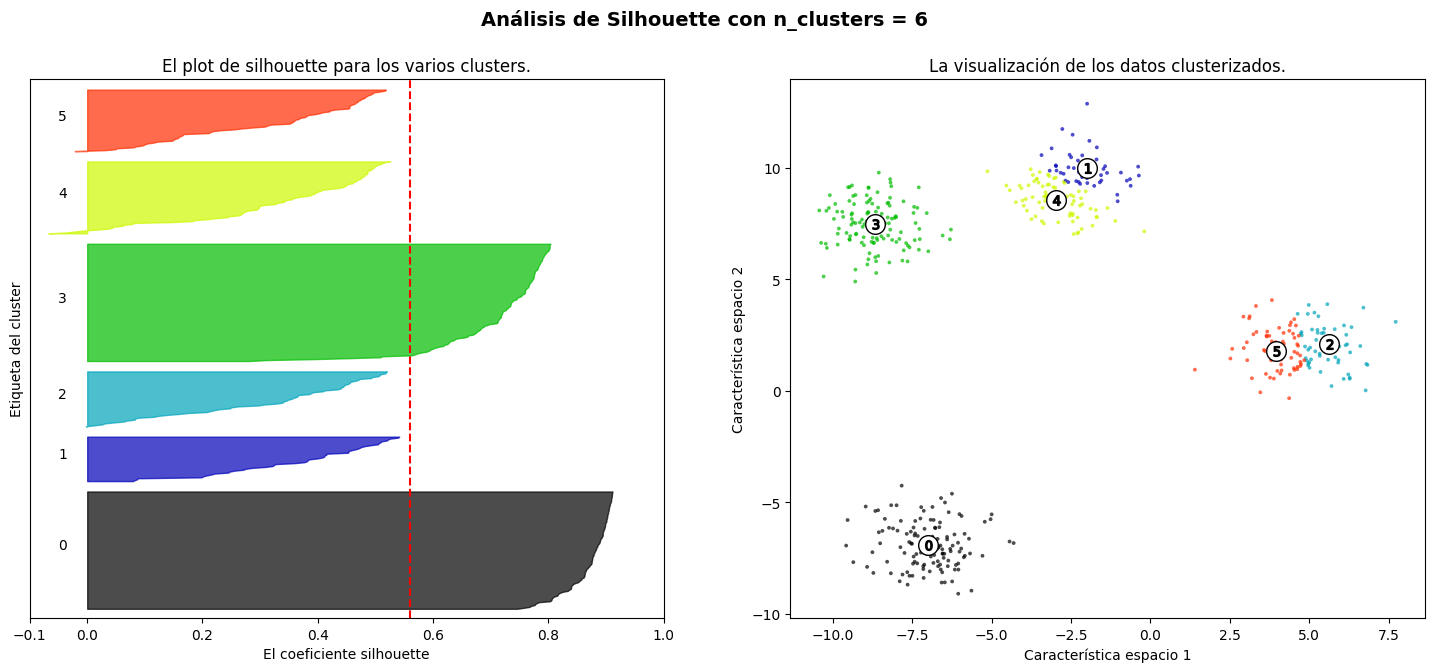

In [ ]:
# Generamos datos de muestra
X, y = make_blobs(n_samples=500, centers=4, cluster_std=1, random_state=42)

# Rango de número de clusters que queremos probar
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Creamos una subplot de 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # El primer subplot es el plot de silhouette
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inicializamos el clusterer con el número de clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto')
    cluster_labels = clusterer.fit_predict(X)

    # El silhouette_score nos da el valor promedio para todos los ejemplos
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El promedio silhouette_score es:", silhouette_avg)

    # Calculamos los silhouette scores para cada ejemplo
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Agregamos los silhouette scores para los ejemplos del cluster i y los ordenamos
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetamos los silhouette plots con sus números de cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 para el 0 de muestras

    ax1.set_title("El plot de silhouette para los varios clusters.")
    ax1.set_xlabel("El coeficiente silhouette")
    ax1.set_ylabel("Etiqueta del cluster")

    # La línea vertical para el silhouette score promedio de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Limpia las etiquetas de y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # El segundo subplot mostrando la clasificación actual de los datos
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Etiquetamos los centros de los clusters
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("La visualización de los datos clusterizados.")
    ax2.set_xlabel("Característica espacio 1")
    ax2.set_ylabel("Característica espacio 2")

    plt.suptitle(("Análisis de Silhouette con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Ejercicios

Añade una función para calcular la distancia Minkowski

Repite varias veces los ejemplos para comprobar que la formación de clusters tiene bastante aleatoriedad cuando los ejemplos están juntos.

Prueba diferentes números de clusters y diferentes métricas de distancia.

Prueba diferentes técnicas (K-medias, K-medians, K-medioides)

En vez de utilizar conjuntos de datos de juguete, prueba a utilizar conjuntos de datos reales como los que hemos utilizado en cuadernos anteriores.

Ahora ya no hay que hacer clasificación ni regresión, simplemente agruparlos por similitud (distancia). <br>
Pero como conocemos la etiqueta de cada uno, podemos comprobar si los clusters obtenidos se corresponden con las clases.